# Projeto 2 - Classificador Automático de Sentimento

Você foi contratado por uma empresa parar analisar como os clientes estão reagindo a um determinado produto no Twitter. A empresa deseja que você crie um programa que irá analisar as mensagens disponíveis e classificará como "relevante" ou "irrelevante". Com isso ela deseja que mensagens negativas, que denigrem o nome do produto, ou que mereçam destaque, disparem um foco de atenção da área de marketing.<br /><br />
Como aluno de Ciência dos Dados, você lembrou do Teorema de Bayes, mais especificamente do Classificador Naive-Bayes, que é largamente utilizado em filtros anti-spam de e-mails. O classificador permite calcular qual a probabilidade de uma mensagem ser relevante dadas as palavras em seu conteúdo.<br /><br />
Para realizar o MVP (*minimum viable product*) do projeto, você precisa implementar uma versão do classificador que "aprende" o que é relevante com uma base de treinamento e compara a performance dos resultados com uma base de testes.<br /><br />
Após validado, o seu protótipo poderá também capturar e classificar automaticamente as mensagens da plataforma.

## Informações do Projeto

Prazo: 13/Set até às 23:59.<br />
Grupo: 1 ou 2 pessoas.<br /><br />
Entregáveis via GitHub: 
* Arquivo notebook com o código do classificador, seguindo as orientações abaixo.
* Arquivo Excel com as bases de treinamento e teste totalmente classificado.

**NÃO disponibilizar o arquivo com os *access keys/tokens* do Twitter.**


### Check 3: 

Até o dia 06 de Setembro às 23:59, o notebook e o xlsx devem estar no Github com as seguintes evidências: 
    * Conta no twitter criada.
    * Produto escolhido.
    * Arquivo Excel contendo a base de treinamento e teste já classificado.

Sugestão de leitura:<br />
http://docs.tweepy.org/en/v3.5.0/index.html<br />
https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/

___

## Preparando o ambiente

Instalando a biblioteca *tweepy* para realizar a conexão com o Twitter:

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

Importando as Bibliotecas que serão utilizadas. Esteja livre para adicionar outras.

In [2]:
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle

___
## Autenticando no  Twitter

Para realizar a captura dos dados é necessário ter uma conta cadastrada no twitter:

* Conta: *** @Rebecamoreno_***


1. Caso ainda não tenha uma: https://twitter.com/signup
1. Depois é necessário registrar um app para usar a biblioteca: https://apps.twitter.com/
1. Dentro do registro do App, na aba Keys and Access Tokens, anotar os seguintes campos:
    1. Consumer Key (API Key)
    1. Consumer Secret (API Secret)
1. Mais abaixo, gere um Token e anote também:
    1. Access Token
    1. Access Token Secret
    
1. Preencha os valores no arquivo "auth.pass"

**ATENÇÃO**: Nunca divulgue os dados desse arquivo online (GitHub, etc). Ele contém as chaves necessárias para realizar as operações no twitter de forma automática e portanto é equivalente a ser "hackeado". De posse desses dados, pessoas mal intencionadas podem fazer todas as operações manuais (tweetar, seguir, bloquear/desbloquear, listar os seguidores, etc). Para efeito do projeto, esse arquivo não precisa ser entregue!!!

In [3]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Coletando Dados

Agora vamos coletar os dados. Tenha em mente que dependendo do produto escolhido, não haverá uma quantidade significativa de mensagens, ou ainda poder haver muitos retweets.<br /><br /> 
Configurando:

In [4]:
#Produto escolhido:
produto = 'Nutella'

#Quantidade mínima de mensagens capturadas:
n = 500
#Quantidade mínima de mensagens para a base de treinamento:
t = 300

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [5]:
#Cria um objeto para a captura
api = tweepy.API(auth)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs = []
for msg in tweepy.Cursor(api.search, q=produto, lang=lang).items():    
    msgs.append(msg.text.lower())
    i += 1
    if i > n:
        break

#Embaralhando as mensagens para reduzir um possível viés
shuffle(msgs)

Salvando os dados em uma planilha Excel:

In [6]:
#Verifica se o arquivo não existe para não substituir um conjunto pronto
if not os.path.isfile('./{0}.xlsx'.format(produto)):
    
    #Abre o arquivo para escrita
    writer = pd.ExcelWriter('{0}.xlsx'.format(produto))

    #divide o conjunto de mensagens em duas planilhas
    dft = pd.DataFrame({'Treinamento' : pd.Series(msgs[:t])})
    dft.to_excel(excel_writer = writer, sheet_name = 'Treinamento', index = False)

    dfc = pd.DataFrame({'Teste' : pd.Series(msgs[t:])})
    dfc.to_excel(excel_writer = writer, sheet_name = 'Teste', index = False)

    #fecha o arquivo
    writer.save()

___
## Classificando as Mensagens

Agora você deve abrir o arquivo Excel com as mensagens capturadas e classificar na Coluna B se a mensagem é relevante ou não.<br /> 
Não se esqueça de colocar um nome para a coluna na célula **B1**.<br /><br />
Fazer o mesmo na planilha de Controle.

___
## Montando o Classificador Naive-Bayes

Com a base de treinamento montada, comece a desenvolver o classificador. Escreva o seu código abaixo:

Opcionalmente: 
* Limpar as mensagens removendo os caracteres: enter, :, ", ', (, ), etc. Não remover emojis.<br />
* Corrigir separação de espaços entre palavras e/ou emojis.
* Propor outras limpezas/transformações que não afetem a qualidade da informação.



### DataFrames para relevante e não é relevante separados (na planilha treinamento):

In [7]:
dft = pd.read_excel('./{0}.xlsx'.format(produto),sheet='Treinamento')
dftsim = dft[(dft.Relevante=="Sim")]
dftnao = dft[(dft.Relevante=="Não")]

### DataFrame para a planilha de teste:

In [8]:
lendo = pd.ExcelFile('./{0}.xlsx'.format(produto))
dfteste = lendo.parse("Teste")

### Função que limpa os tweets (remove vírgulas, aspas, nomes dos usuários,...):

In [9]:
def limpadorcaracter(frase):
    #rodando para cada palavra da frase recebida 
    for palavra in frase.split():
        #igualando algumas expressões à correta
        if palavra == 'oq':
            frase = frase.replace('oq',"o que")
            palavra = palavra.replace('oq',"o que")
        if palavra == 'hj':
            frase = frase.replace('hj',"hoje")
            palavra = palavra.replace('hj',"hoje")
        if palavra == 'pq' or palavra == 'porq':
            frase = frase.replace(palavra,"porque")
            palavra = palavra.replace(palavra,"porque")
        if palavra == 'dnv':
            frase = frase.replace('dnv',"de novo")
            palavra = palavra.replace('dnv',"de novo")
        if palavra == 'cê' or palavra == 'vc':
            frase = frase.replace(palavra,"você")
            palavra = palavra.replace(palavra,"você")
            #print(frase.replace(palavra,"você"))
            #print(palavra)
        if palavra == 'n' or palavra == 'nao':
            frase = frase.replace(palavra,"não")
            palavra = palavra.replace(palavra,"não")
        if palavra == 'vcs':
            frase = frase.replace(palavra,"vocês")
            palavra = palavra.replace(palavra,"vocês")
        if palavra == 'mds':
            frase = frase.replace('mds',"meu deus")
            palavra = palavra.replace('mds',"meu deus")
        if palavra == 'td':
            frase = frase.replace('td',"tudo")
            palavra = palavra.replace('td',"tudo")
        if palavra == 'eae' or palavra == 'eai' or palavra == 'oii':
            frase = frase.replace(palavra,"oi")
            palavra = palavra.replace(palavra,"oi")
        if palavra == 'mt' or palavra == 'mto':
            frase = frase.replace(palavra,"muito")
            palavra = palavra.replace(palavra,"muito")
        #rodando para cada letra da palavra
        for letras in palavra:
            if letras == '@' or 'https:'in palavra or 'https://t.co/' in palavra or 'https' in palavra or 't.co' in palavra or 'kk' in palavra or 'kkk' in palavra: 
                frase = frase.replace(palavra,"").replace('  ',' ')
            if (letras == (",") or letras == "'" or letras == '"' or letras == '[' or letras == '‹' or letras == ']' or letras == '#' or letras == ':' or letras == ';' or letras == '›' or letras == '!' or letras == '(' or letras == ')' or letras == '/' or letras == '\n' or letras == '.' or letras == '\\' or letras == '-' or letras == '$' or letras == '%' or letras == '|' or letras == '=' or letras == '*' or letras == 'ˆ' or letras == '&' or letras == '+' or letras == ('?')):
                palavra = palavra.replace(letras," ")
                frase = frase.replace(letras," ")
        frase = frase.split()
        frase = " ".join(frase)
        
    return frase

### Contagem do total de palavras nos tweets:

In [10]:
A = {}     #Dicionário com as palavras dos tweets
todas = 0  #Contador das palavras no total 
c=0        #Frequência da palavra mais frequente

#para cada post (msg)
for msg in dft["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra já limpa
        #contando sua frenquencia e adicionando em A
        if not i in A:
            A[i]=0
        A[i]+=1
        todas+=1
        if A[i]>=c:
            c=A[i]
            string = i
print('Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(string,c))

Como curiosidade, a palavra que aparece com mais frequência em toda essa análise é a palavra "nutella", com uma frenquência de 221 vezes.



### Contagem do total de palavras relevantes:

In [11]:
S = {}            #Dicionário com as palavras em relevantes dos tweets
todas_em_sim = 0  #Contador das palavras no sim
p = 0             #Frequência da palavra mais frequente

#para cada post (msg)
for msg in dftsim["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra já limpa
        #contando sua frenquencia e adicionando em S
        if not i in S:
            S[i]=0
        S[i]+=1
        todas_em_sim+=1
        if S[i]>=p:
            p=S[i]
            strings = i
            
print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(strings,p))

Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de RELEVANTES é a palavra "nutella", com uma frenquência de 137 vezes.



### Contagem do total de palavras não relevantes:

In [12]:
N = {}            #Dicionário com as palavras em não relevantes dos tweets
todas_em_nao = 0  #Contador das palavras no não
f = 0             #Frequência da palavra mais frequente

#para cada post (msg)
for msg in dftnao["Treinamento"]:
    #para cada palavra dentro do post (i)
    frase = limpadorcaracter(msg)
    for i in frase.split():
        #analisando cada palavra já limpa
        #contando sua frenquencia e adicionando em N
        if not i in N:
            N[i]=0
        N[i]+=1
        todas_em_nao+=1
        if N[i]>=f:
            f=N[i]
            stringn = i

print('Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de NÃO RELEVANTES é a palavra "{0}", com uma frenquência de {1} vezes.\n'.format(stringn,f))

Como curiosidade, a palavra que aparece com mais frequência entre todas as palavras de NÃO RELEVANTES é a palavra "nutella", com uma frenquência de 84 vezes.



### Resultados:

In [13]:
print('A quantidade TOTAL de palavras no UNIVERSO é {0}.'.format(todas))
print('A quantidade TOTAL de palavras dentro de RELEVANTES é {0}.'.format(todas_em_sim))
print('A quantidade TOTAL de palavras dentro de NÃO RELEVANTES é {0}.\n'.format(todas_em_nao))
print('A quantidade de palavras DIFERENTES no UNIVERSO é {0}.'.format(len(A)))
print('A quantidade de palavras DIFERENTES dentro de RELEVANTES é {0}.'.format(len(S)))
print('A quantidade de palavras DIFERENTES dentro de NÃO RELEVANTES é {0}.'.format(len(N)))

A quantidade TOTAL de palavras no UNIVERSO é 3593.
A quantidade TOTAL de palavras dentro de RELEVANTES é 1686.
A quantidade TOTAL de palavras dentro de NÃO RELEVANTES é 1907.

A quantidade de palavras DIFERENTES no UNIVERSO é 1163.
A quantidade de palavras DIFERENTES dentro de RELEVANTES é 569.
A quantidade de palavras DIFERENTES dentro de NÃO RELEVANTES é 770.


___
## Verificando a performance

Agora você deve testar o seu Classificador com a base de Testes.<br /><br /> 

Você deve extrair as seguintes medidas:
* Porcentagem de positivos falsos (marcados como relevante mas não são relevantes)
* Porcentagem de positivos verdadeiros (marcado como relevante e são relevantes)
* Porcentagem de negativos verdadeiros (marcado como não relevante e não são relevantes)
* Porcentagem de negativos falsos (marcado como não relevante e são relevantes)

Opcionalmente:
* Criar categorias intermediárias de relevância baseado na diferença de probabilidades. Exemplo: muito relevante, relevante, neutro, irrelevante e muito irrelevante.

### Variáveis:

In [14]:
#Calculando a probabilidade de cada palavra de ser relevante ou nao, para depois calcular a de cada frase de ser relevante ou nao
#Teorema de Naive Bayes: 
#P(sim|palavra)=(P(palavra|sim)+1) / P(palavras totais|sim)+P(palavras totais sem repetição)
#Em outras palavras:
#A prob de ser relevante dada a palavra é igual a prob da palavra dado que ela é relevante mais 1 
#(para o caso de a palavra nao existir no grupo de relevantes), tudo isso dividido pela prob de todas as palavras dentro de relevante
#mais a prob das palavras totais sem repeticao do universo inteiro.

bs = todas_em_sim                      #Total de palavras em relevante
bn = todas_em_nao                      #Total de palavras em não relevante
c = len(A)                             #Palvras totais sem repetições
PS = {}                                #Dicionário de prbabilidades de cada palavra em relevante
PN = {}                                #Dicionário de prbabilidades de cada palavra em não relevante
TSim = dftsim["Treinamento"].count()   #Nº de tweets relevantes
TNao = dftnao["Treinamento"].count()   #Nº de tweets não relevantes
TTotal = dft["Treinamento"].count()    #Nº total de tweets
ListaPtweetS=[]                        #Probabilidade de cada tweet em relevante
ListaPtweetN=[]                        #Probabilidade de cada tweet em não relevante
Resultado=[]                           #Lista com "Sim" e "Não" qu irá para o dataframe

### Cálculo da probabilidade de cada tweet:

In [15]:
for msg2 in dfteste['Teste']:
    #Para sim:
    PtweetS = (TSim/TTotal)
    for i in msg2.split():
        frase = limpadorcaracter(msg2)
        if i in S:
            PS[i] = (S[i]+1)/(bs+c)
        else:
            PS[i] = 1/(bs+c)
        PtweetS = PtweetS*PS[i]
    ListaPtweetS.append(PtweetS)

    #Para não:
    PtweetN = (TNao/TTotal)
    for i in msg2.split():
        frase = limpadorcaracter(msg2)
        if i in N:
            PN[i] = (N[i]+1)/(bn+c)
        else:
            PN[i] = 1/(bn+c)
        PtweetN = PtweetN*PN[i]
    ListaPtweetN.append(PtweetN)

### Criando uma coluna de resultado na planilha de teste:

In [16]:
for i in range(len(ListaPtweetS)):
    #Se a Probabilidade da frase for maior em Relevante do que Irrelevante, então, classifique-a como Relevante
    if ListaPtweetS[i]>ListaPtweetN[i]:
        Resultado.append("Sim")
    #Caso contrário, classifique-a como Não Relevante
    if ListaPtweetN[i]>ListaPtweetS[i]:
        Resultado.append("Não")
        
#criando a coluna Resultado, ou seja, os resultados do Classificador conforme as probabilidades 
#das frases de estarem ou em Relevante ou em Não Relevante
dfteste["Resultado"] = Resultado

### Calculando resultados iguais e diferentes:

In [17]:
Igual = 0
Diferente = 0
#para cada post de Teste:
for i in range(dfteste["Teste"].count()):
#se a resposta de Relevante for igual a resposta de Resultado entao adicione um a Igual (eles sao iguais)
    if dfteste["Relevante"][i] == dfteste["Resultado"][i]:
        Igual+=1
    else:
        Diferente+=1
print('{0} respostas feitas pelo Classificador coincidem com o grupo de Relevante. Ou seja, {1}% das respostas do Classificador são bem sucedidas.'.format(Igual,Igual/(Igual+Diferente)*100))
print('Enquanto que {0} respostas feitas pelo Classificador não coincidem com o grupo de Relevante. Ou seja, {1}% das respostas do Classificador são mal sucedidas.'.format(Diferente,Diferente/(Igual+Diferente)*100))

168 respostas feitas pelo Classificador coincidem com o grupo de Relevante. Ou seja, 84.0% das respostas do Classificador são bem sucedidas.
Enquanto que 32 respostas feitas pelo Classificador não coincidem com o grupo de Relevante. Ou seja, 16.0% das respostas do Classificador são mal sucedidas.


### Calculando resultados para positivos e negativos, tanto falsos quanto verdadeiros:

In [18]:
#definindo as variaveis para confirmar os positivos e negativos
PosFalso = 0
PosVer = 0
NegVer = 0
NegFalso = 0
#criando a lista que guardará as strings classificadoras ('Positivo Falso','Positivo Verdadeiro','Negativo Verdadeiro' e 'Negativo Falso')
PeN = []

for i in range(dfteste["Teste"].count()):
    #analisando os resultados, do mesmo post, do Classificador e do grupo Relevante feito por nós e adicionando a lista
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Sim':
        PosFalso+=1
        PeN.append('Positivo Falso')

    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Sim':
        PosVer+=1
        PeN.append('Positivo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Não' and dfteste["Resultado"][i]=='Não':
        NegVer+=1
        PeN.append('Negativo Verdadeiro')
        
    if dfteste["Relevante"][i]=='Sim' and dfteste["Resultado"][i]=='Não':
        NegFalso+=1
        PeN.append('Negativo Falso')        

#adicinando a coluna ao DataFrame
dfteste["pn"] = PeN

In [19]:
print('Quantidade dos respectivos Positivos e Negativos (sem porcentagem):')
dfteste.pn.value_counts()

Quantidade dos respectivos Positivos e Negativos (sem porcentagem):


Positivo Verdadeiro    87
Negativo Verdadeiro    81
Positivo Falso         21
Negativo Falso         11
Name: pn, dtype: int64

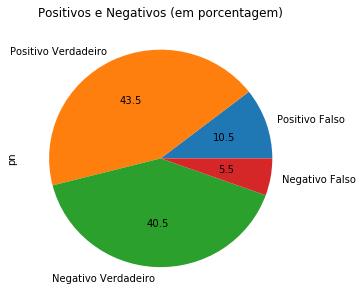

In [20]:
import matplotlib.pyplot as plt
k = dfteste.pn.value_counts()/len(PeN)*100
s = k.reindex(['Positivo Falso','Positivo Verdadeiro','Negativo Verdadeiro','Negativo Falso'])
plot = s.plot(kind='pie',title='Positivos e Negativos (em porcentagem)',autopct='%.1f',figsize=(5, 5))
plt.show()

        Neste gráfico de setor, percebemos que a porcentagem de positivos verdadeiros e de negativos verdadeiros classificados é de 43% e 41%, respectivamente, o que significa que, em sua maioria, o Classificador usado funciona para 84% dos casos (a soma dos dois verdadeiros). Com isso, concluimos que, como as respostas do nosso Classificador coincidem 168 vezes dentre 200 (84%), ele poderia melhorar, chegando perto de 100% de sucesso, entretanto nunca chegaria a acertar as 200 vezes.

___
## Concluindo

Escreva aqui a sua conclusão.<br /> 
Faça um comparativo qualitativo sobre as medidas obtidas.<br />
Explique como são tratadas as mensagens com dupla negação e sarcasmo.<br />
Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?<br />

Opcionalmente: 
* Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.
* Propor diferentes cenários de uso para o classificador Naive-Bayes. Cenários sem intersecção com este projeto.
* Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer e material de pesquisa sobre o assunto).


Como dito anteriormente, o Classificador funciona para 84% dos casos, o que é bom, pois coincide em boa parte dos resultados esperados. Entretanto, é certo que poderia melhorar. O maior obstáculo nisso é pelo fato de o Twitter ser uma rede social de caráter informal, ou seja, as pessoas se expressam do jeito que querem (com sarcasmo, com expressões diferentes, com gírias, escrevem do jeito que falam, entre outros), e por causa disso, muito dificilmente o filtro será perfeito para todos os casos. Se temos uma frase, por exemplo, em que a pessoa é sarcástica, o Classificador lerá como uma frase normal e a classificará do jeito errado.

Por conta disso, propusemos um plano de expansão: filtrar e igualar mais expressões além das feitas, como "dnv" a "de novo", separar todos os emojis das palavras e entre si, igualar os tipos de risada como "haha" a "rsrs" e a "kkk", filtrar a expressão que aparece frequentemente no grupo de não relevante ("geração raíz" e "geração nutella"), assim como filtrar os outros "memes" (que significa "imitação" em grego e também "informações virais" dentro da internet). É claro que, ao escrever, as pessoas podem errar na digitação, como escrever "amnhã" ao invés de "amanhã", ou fazer de propósito, e isso pode passar como uma probabilidade errada por só haver uma expressão daquela dentre muitas palavras do evento.

Para realizar este plano, um dos modos é igualar a expressão usada àquela correspondente assim que ela aparecer na análise. Ou seja, fazendo a análise de cada frase dentro da análise toda (em termos de programação: "for frase in dataframe_usado:") e para todas as palavras da respectiva frase (em termos de programação: "for palavra in frase.split():") e, usando cada palavra para verificar se ela é igual a nossa expressão (em termos de programação: "if palavra == 'oq':", por exemplo, que foi a expressão usada por nós), então substitua na frase a palavra usada pelo usuário pela correta (em termos de programação: "frase = frase.replace('oq','o que')). Para implementar esta melhoria no nosso código, devemos adicionar esta limpeza na função que está limpando, para que limpe todos os casos, e, além disso, devemos fazer essa mudança de palavra antes de separarmos a frase para analisar cada palavra (em termos de programação: "antes do for de frase.split()"). Se fizermos isto para outras expressões, nosso código melhoraria bastante. No caso da separação de emojis, o código fica diferente, pois chamamos, por exemplo, um emoji específico sorrindo de "\U0001f601". Mais informações sobre como resolver estes casos em: https://stackoverflow.com/…/how-to-encode-emojis-that-are-i… .

Para a classificação do emoji, tanto em irônico quanto não irônico, o professor Scott Fahlmano, assistente de pesquisa de ciência da computação da Universidade Carnegie Mellon, nos Estados Unidos, e criador do primeiro emoticon, propôs o ícone ":-)", chamado de "smiley" para identificar mensagens de piada e ":-(" para as sérias. A ideia foi concebida para resolver um mal-entendido ocorrido na instituição por uma mensagem sarcástica (mais informações sobre isso em http://www.techtudo.com.br/…/entenda-diferenca-entre-smiley…). Este argumento nos permite separar o que seria sarcasmo ou ironia (se houver o ícone ":-)") do que seria realidade ou coisa séria (que é como o nosso Classificador lê naturalmente).

Com o financiamento, o filtro poderá detectar algumas das expressões mais usadas pelos jovens que acessam essas redes sociais. Afinal, somos nós, jovens, conhecedores das expressões populares, que aperfeiçoamos o Classificador.

Importante mencionar que o motivo pelo qual o classificador foi implementado apenas para a base de testes foi para garantir que o cálculo não fique enviesado. Por exemplo, quando calculamos a probabilidade de uma palavra aleatória (que não interfere na classificação, como uma preposição) ser relevante ou não, muitas vezes o resultado tende para uma das classificações, aumentando a chance do classificador "acertar" a relevância do tweet.